In [ ]:
import numpy as np
import cv2
import os
import sys
import random
import matplotlib.pyplot as plt

N = 2500
variance = 0.001
batch_size = 50

## Building the perceptron

Using a class to build the model because it makes it easier to update the weights and the biases as the algorithm progresses.

In [2]:
class model():

  # initialise the model parameters
  def __init__(self, learning_rate=0.05, epochs=100):
    self.learning_rate = learning_rate
    self.epochs = epochs

    self.w1 = np.random.randn(2, 2) # weights for the hidden layer
    self.w2 = np.random.randn(2, 1) # weights for the output layer
    self.b1 = np.random.randn(1, 2) # bias for the hidden layer
    self.b2 = np.random.randn(1, 1) # bias for the output layer

    self.MSE = []

    self.z1 = None
    self.a1 = None # activation of the hidden layer
    self.z2 = None
    self.a2 = None # activation of output


  # sigmoid function
  def sigmoid(self, x):
    return 1 / (1 + np.exp(-1 * x))

  # derivative of the sigmoid function
  def d_sigmoid(self, x):
    return x * (1 - x)

  # forward pass
  def forward(self, X):
    self.z1 = np.dot(X, self.w1) + self.b1
    self.a1 = self.sigmoid(self.z1)

    self.z2 = np.dot(self.a1, self.w2) + self.b2
    self.a2 = self.sigmoid(self.z2)

    return self.a2

  # backward pass to update weights
  def backward(self, X, labels):

    # MSE
    R = 0.5 * (labels - self.a2) ** 2
    # R = R.sum() / labels.shape[0]
    R = R.sum()
    self.MSE.append(R)

    # delta for weights corressponding to the outer layer
    delta_w2 = -2 * np.dot(self.a1.T, (labels - self.a2) * self.d_sigmoid(self.a2))
    # delta for weights corressponding to the inner layer
    delta_w1 = -2 * np.dot(X.T, (((labels - self.a2) * self.d_sigmoid(self.a2)) * self.w2.T) * self.d_sigmoid(self.a1))

    # updating weights
    self.w2 = self.w2 - self.learning_rate * delta_w2
    self.w1 = self.w1 - self.learning_rate * delta_w1

    # delta for bias corressponding to the outer layer
    delta_b2 = -2 * (labels - self.a2) * self.d_sigmoid(self.a2)
    delta_b2 = np.dot(np.ones(delta_b2.shape[0]), delta_b2)
    # delta for bias corressponding to the inner layer
    delta_b1 = -2 * (((labels - self.a2) * self.d_sigmoid(self.a2)) * self.w2.T) * self.d_sigmoid(self.a1)
    delta_b1 = np.dot(np.ones(delta_b1.shape[0]), delta_b1)
    
    # updating bias
    self.b2 = self.b2 - self.learning_rate * delta_b2
    self.b1 = self.b1 - self.learning_rate * delta_b1

  # function to classify the test set
  def classify(self, test_set):
    return self.forward(test_set)



## XOR

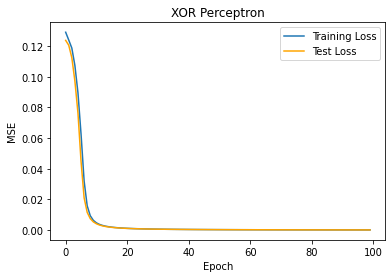


MODEL PARAMETERS:

Hidden Layer Weights:
 [[4.66545825 6.3863302 ]
 [4.65115901 6.40098336]]
Hidden Layer Biases:
 [[-7.14808811 -2.83945991]]
Output Layer Weights:
 [[-10.28250795]
 [  9.62646408]]
Output Layer Biases:
 [[-4.47059854]]


In [ ]:
def XOR(N, variance):

  X = np.zeros((N, 2))
  y = np.zeros((N, 1))
  
  step = int(N // 4)
  last_index = 0

  # generating a well balanced dataset
  for i in range(0, step):

    X[i][0] = 0
    X[i][1] = 0

    X[i + step][0] = 0
    X[i + step][1] = 1

    X[i + 2 * step][0] = 1
    X[i + 2 * step][1] = 0

    X[i + 3 * step][0] = 1
    X[i + 3 * step][1] = 1

    last_index = i + 3 * step

  # for cases where N is not divisible by 4
  for i in range(last_index + 1, N):
    X[i][0] = random.randrange(1, 100) % 2
    X[i][1] = random.randrange(1, 100) % 2

  # shuffling the generated data to randomise it for training and test sets
  np.take(X, np.random.permutation(X.shape[0]), axis=0, out=X)
  
  # computing the labels
  y = np.logical_xor(X[:, 0], X[:, 1])
  y = y.astype(int)
  
  # adding noise to the input
  X = X + np.random.normal(0, variance, (N, 2))

  return X, y

XOR_data, XOR_labels = XOR(N, variance)

# splitting the dataset into test and train
split = int(N * 0.8)
X_train, y_train = XOR_data[0:split, :], XOR_labels[0:split]
X_test, y_test = XOR_data[split:N, :], XOR_labels[split:N]

y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

# initialising the model
XOR_m = model()
batches = int(N / batch_size)

XOR_MSE = []
XOR_test_loss = []

# training the model
for _ in range(XOR_m.epochs):
  # passing separate batches in the same epoch
  for i in range(batches):
    XOR_m.forward(X_train[i * batch_size : i * batch_size + batch_size, :])
    XOR_m.backward(X_train[i * batch_size : i * batch_size + batch_size, :], y_train[i * batch_size : i * batch_size + batch_size])
  
  # computing training loss
  XOR_MSE.append(sum(XOR_m.MSE)/X_train.shape[0])
  # print("MSE:", sum(XOR_m.MSE)/X_train.shape[0])
  XOR_m.MSE = []

  # computing testing loss
  predictions = XOR_m.classify(X_test)
  R = 0.5 * (y_test - predictions) ** 2
  R = R.sum() / predictions.shape[0]
  XOR_test_loss.append(R)
  # print("Testing loss:", R)

# plotting the train and test errors
plt.plot(XOR_MSE, label="Training Loss") # training loss
plt.plot(XOR_test_loss, c='orange', label="Test Loss") # test loss
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("XOR Perceptron")
plt.show()

print("\nMODEL PARAMETERS:\n")
print("Hidden Layer Weights:\n", XOR_m.w1)
print("Hidden Layer Biases:\n", XOR_m.b1)
print("Output Layer Weights:\n", XOR_m.w2)
print("Output Layer Biases:\n", XOR_m.b2)

## AND

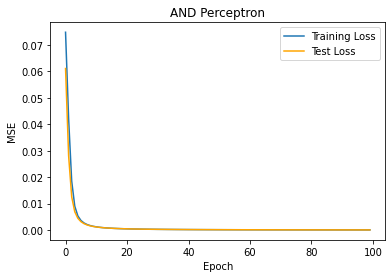


MODEL PARAMETERS:

Hidden Layer Weights:
 [[-2.01285322 -4.25972571]
 [-2.164448   -4.1622695 ]]
Hidden Layer Biases:
 [[2.23293634 5.80667142]]
Output Layer Weights:
 [[-3.64159686]
 [-9.20233552]]
Output Layer Biases:
 [[5.05193412]]


In [ ]:
def AND(N, variance):

  X = np.zeros((N, 2))
  y = np.zeros((N, 1))
  
  step = int(N // 4)
  last_index = 0

  # generating a well balanced dataset
  for i in range(0, step):

    X[i][0] = 0
    X[i][1] = 0

    X[i + step][0] = 0
    X[i + step][1] = 1

    X[i + 2 * step][0] = 1
    X[i + 2 * step][1] = 0

    X[i + 3 * step][0] = 1
    X[i + 3 * step][1] = 1

    last_index = i + 3 * step

  # for cases where N is not divisible by 4
  for i in range(last_index + 1, N):
    X[i][0] = random.randrange(1, 100) % 2
    X[i][1] = random.randrange(1, 100) % 2

  # shuffling the generated data to randomise it for training and test sets
  np.take(X, np.random.permutation(X.shape[0]), axis=0, out=X)
  
  # computing the labels
  y = np.logical_and(X[:, 0], X[:, 1])
  y = y.astype(int)
  
  # adding noise to the input
  X = X + np.random.normal(0, variance, (N, 2))

  return X, y

AND_data, AND_labels = AND(N, variance)

# splitting the dataset into test and train
split = int(N * 0.8)
X_train, y_train = AND_data[0:split, :], AND_labels[0:split]
X_test, y_test = AND_data[split:N, :], AND_labels[split:N]

y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

# initialising the model
AND_m = model()
batches = int(N / batch_size)

AND_MSE = []
AND_test_loss = []

# training the model
for _ in range(AND_m.epochs):
  # passing separate batches in the same epoch
  for i in range(batches):
    AND_m.forward(X_train[i * batch_size : i * batch_size + batch_size, :])
    AND_m.backward(X_train[i * batch_size : i * batch_size + batch_size, :], y_train[i * batch_size : i * batch_size + batch_size])
  
  # computing training loss
  AND_MSE.append(sum(AND_m.MSE)/X_train.shape[0])
  # print("MSE:", sum(AND_m.MSE)/X_train.shape[0])
  AND_m.MSE = []

  # computing testing loss
  predictions = AND_m.classify(X_test)
  R = 0.5 * (y_test - predictions) ** 2
  R = R.sum() / predictions.shape[0]
  AND_test_loss.append(R)
  # print("Testing loss:", R)

# plotting the train and test errors
plt.plot(AND_MSE, label="Training Loss") # training loss
plt.plot(AND_test_loss, c='orange', label="Test Loss") # test loss
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("AND Perceptron")
plt.show()

print("\nMODEL PARAMETERS:\n")
print("Hidden Layer Weights:\n", AND_m.w1)
print("Hidden Layer Biases:\n", AND_m.b1)
print("Output Layer Weights:\n", AND_m.w2)
print("Output Layer Biases:\n", AND_m.b2)

## OR

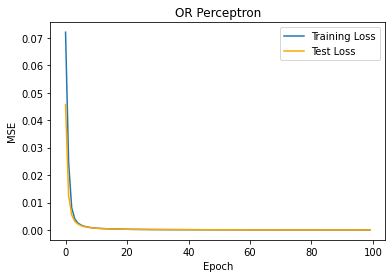


MODEL PARAMETERS:

Hidden Layer Weights:
 [[-1.95067881  4.90782868]
 [-2.4298157   4.50756244]]
Hidden Layer Biases:
 [[ 1.09598293 -2.33616274]]
Output Layer Weights:
 [[-3.92672277]
 [ 8.57373575]]
Output Layer Biases:
 [[-2.09982313]]


In [ ]:
def OR(N, variance):

  X = np.zeros((N, 2))
  y = np.zeros((N, 1))
  
  step = int(N // 4)
  last_index = 0

  # generating a well balanced dataset
  for i in range(0, step):

    X[i][0] = 0
    X[i][1] = 0

    X[i + step][0] = 0
    X[i + step][1] = 1

    X[i + 2 * step][0] = 1
    X[i + 2 * step][1] = 0

    X[i + 3 * step][0] = 1
    X[i + 3 * step][1] = 1

    last_index = i + 3 * step

  # for cases where N is not divisible by 4
  for i in range(last_index + 1, N):
    X[i][0] = random.randrange(1, 100) % 2
    X[i][1] = random.randrange(1, 100) % 2

  # shuffling the generated data to randomise it for training and test sets
  np.take(X, np.random.permutation(X.shape[0]), axis=0, out=X)
  
  # computing the labels
  y = np.logical_or(X[:, 0], X[:, 1])
  y = y.astype(int)
  
  # adding noise to the input
  X = X + np.random.normal(0, variance, (N, 2))

  return X, y

OR_data, OR_labels = OR(N, variance)

# splitting the dataset into test and train
split = int(N * 0.8)
X_train, y_train = OR_data[0:split, :], OR_labels[0:split]
X_test, y_test = OR_data[split:N, :], OR_labels[split:N]

y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

# initialising the model
OR_m = model()
batches = int(N / batch_size)

OR_MSE = []
OR_test_loss = []

# training the model
for _ in range(OR_m.epochs):
  # passing separate batches in the same epoch
  for i in range(batches):
    OR_m.forward(X_train[i * batch_size : i * batch_size + batch_size, :])
    OR_m.backward(X_train[i * batch_size : i * batch_size + batch_size, :], y_train[i * batch_size : i * batch_size + batch_size])
  
  # computing training loss
  OR_MSE.append(sum(OR_m.MSE)/X_train.shape[0])
  # print("MSE:", sum(OR_m.MSE)/X_train.shape[0])
  OR_m.MSE = []

  # computing testing loss
  predictions = OR_m.classify(X_test)
  R = 0.5 * (y_test - predictions) ** 2
  R = R.sum() / predictions.shape[0]
  OR_test_loss.append(R)
  # print("Testing loss:", R)

# plotting the train and test errors
plt.plot(OR_MSE, label="Training Loss") # training loss
plt.plot(OR_test_loss, c='orange', label="Test Loss") # test loss
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("OR Perceptron")
plt.show()

print("\nMODEL PARAMETERS:\n")
print("Hidden Layer Weights:\n", OR_m.w1)
print("Hidden Layer Biases:\n", OR_m.b1)
print("Output Layer Weights:\n", OR_m.w2)
print("Output Layer Biases:\n", OR_m.b2)

## Observations

The larger the value of N, the faster the network seems to converge. A model with $N = 5000$ converged much faster than a model with $N = 1000$.

Setting the learning rate to a higher value (e.g.: $\gamma = 0.5$) caused the model to converge rather abruptly to a value that is not the global minimum and caused a few fluctuations. That is, the MSE wasn't a smooth downward slope, it had a lot of abrupt highs and lows. And in some cases, the high learning rate didn't allow the model to converge at all.

On the other hand, setting the learning rate to very low values like $\gamma = 0.000001$ caused it to converge very slowly: over the course of $100$ epochs, the train and test error lines appear to be almost straight lines.

Neight of the three models seems to either overfit or underfit.